In [2]:
import os
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import cm
from random import randint
from typing import Optional
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import MeanIoU

import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchmetrics import JaccardIndex

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DATADIR = 'DATASET/'

In [3]:
def image_rz(img):
  height = img.shape[0]
  width = img.shape[1]
  problem = abs(height - width)
  sz = [int(problem / 2), problem - int(problem / 2), 0]
  if width >= height:
    img = cv2.copyMakeBorder(img, sz[0], sz[1], sz[2],
                            sz[2], cv2.BORDER_CONSTANT)
  else:
    img = cv2.copyMakeBorder(img, sz[2], sz[2], sz[0],
                            sz[1], cv2.BORDER_CONSTANT)
  img = cv2.resize(img, (256, 256))
  return img

In [4]:
images_path = DATADIR + 'images/'
masks_path = DATADIR + 'masks/'

file_names = os.listdir(images_path)
images = []
for fname in sorted(file_names):
  image_path = os.path.join(images_path, fname)
  image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
  image = image_rz(image)
  images += [image]

file_names = os.listdir(masks_path)
masks = []
for fname in sorted(file_names):
  mask_path = os.path.join(masks_path, fname)
  mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
  mask = image_rz(mask)
  masks += [mask]

In [5]:
train_im, test_im, train_mk, test_mk = train_test_split(images, masks, test_size = 0.20)

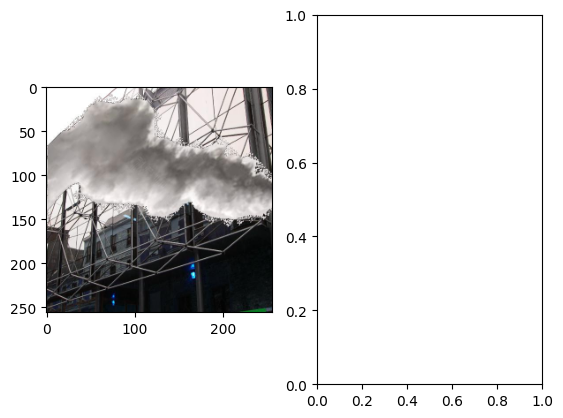

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(test_im[0])
# ax2.imshow(train_mk[3300])

In [7]:
class SmokeDataset(Dataset):
    
    def __init__(self, images, masks, transforms):
        self.images = images
        self.masks = masks
        self.transforms = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        mask = self.masks[index]
        image = self.transforms(image)
        
        return image, mask

In [8]:
train_batch_size=4
test_batch_size=4
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.4992, 0.5037, 0.5032), (0.2844, 0.2635, 0.2712))])

train_set = SmokeDataset(train_im, train_mk, transform)
test_set = SmokeDataset(test_im, test_mk, transform)

train_loader = DataLoader(train_set, train_batch_size, shuffle=True)
test_loader = DataLoader(test_set, test_batch_size)

In [9]:
# mean = torch.tensor([0., 0., 0.])
# std = torch.tensor([0., 0., 0.])
# for data in train_loader:
#   img, mask = data
#   mean += img.mean([0, 2, 3])
#   std += img.std([0, 2, 3]) 
# mean /= len(train_loader)
# std /= len(train_loader)
# print(mean, std)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


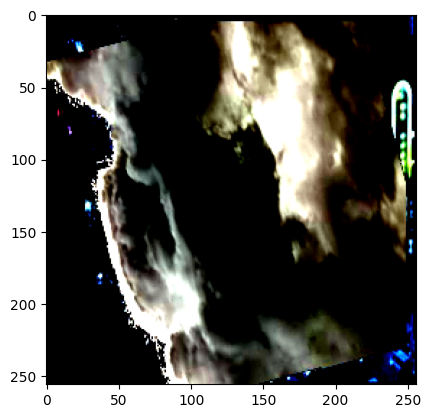

In [10]:
fig, ax = plt.subplots(1, 1)
for data in train_loader:
  img, mask = data
  image = img[0].permute(1, 2, 0).numpy()
  ax.imshow(image)
  break

In [11]:
model = torch.hub.load(
        'mateuszbuda/brain-segmentation-pytorch',
        'unet',
        in_channels=3,
        out_channels=1,
        init_features=32,
        pretrained=True,
    )
model.to(device)
for name, param in model.named_parameters():
  if 'encoder1' in name or 'encoder2' in name:
    param.requires_grad = False
  if 'decoder1' in name or 'decoder2' in name:
    param.requires_grad = False
  if 'upconv1' in name or 'upconv2' in name:
    param.requires_grad = False

Using cache found in C:\Users\ilyas/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master


In [12]:
def show_loss(train_loss):
    fig=plt.figure(figsize=(10, 7))
    plt.plot(np.arange(1, len(train_loss)+1), train_loss, label="Train loss")
    plt.xlabel('Loss')
    plt.ylabel('Epochs')
    plt.title("Loss Plots")
    plt.legend(loc='upper right')
    plt.show()

In [13]:
def iou(realMask, resultMask):
  acc = 0.0
  for mask_orig, mask in zip(realMask, resultMask):
    m = JaccardIndex(num_classes=2)
    acc += m(mask_orig, mask)
  return acc

In [14]:
def train(model, loss_fn, train_loader, test_loader, learning_rate=1e-4, num_epoch=20):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_loss = []
    test_loss = []
    
    for epoch in range(num_epoch):
        model.train()
        epoch_loss = 0
        
        for i, data in enumerate(train_loader):
            optimizer.zero_grad()
            images, masks_orig = data
            images = images.to(device)
            masks_orig = masks_orig.to(device)
            masks = model(images)
            if(mask.shape[0] != 1):
                masks = torch.squeeze(masks)
            else:
                masks = torch.squeeze(masks)
                masks = masks.reshape((1,256,256))
            masks_orig = masks_orig.float()/255.0
            loss = loss_fn(masks, masks_orig)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()

        epoch_loss = epoch_loss/(i+1)
        train_loss.append(epoch_loss) 
        print("Epoch: {} Train Loss: {:.4}".format(epoch, epoch_loss))

        model.eval()
        acc = 0
        for i, data in enumerate(test_loader):
            images, masks_orig = data
            images = images.to(device)
            masks_orig =  masks_orig.to(device)
            masks = model(images)
           # if(mask.shape[0] != 1):
           #     masks = torch.squeeze(masks)
           # else:
           #     masks = torch.squeeze(masks)
           #     masks = masks.reshape((1,256,256))

           # masks = (masks * 255).int()
           # acc_batch = iou(masks_orig, masks)
            
           # acc += acc_batch/len(images)
        acc = acc/(i+1)
        print("Epoch: {} Test Acc: {:.4}\n".format(epoch, acc))
    
#    show_loss(train_loss)
    return acc

In [15]:
loss_fn = torch.nn.BCELoss()
train(model, loss_fn, train_loader, test_loader)

Epoch: 0 Train Loss: 0.7782
Epoch: 0 Test Acc: 0.0

Epoch: 1 Train Loss: 0.2921
Epoch: 1 Test Acc: 0.0

Epoch: 2 Train Loss: 0.2067
Epoch: 2 Test Acc: 0.0

Epoch: 3 Train Loss: 0.1669
Epoch: 3 Test Acc: 0.0

Epoch: 4 Train Loss: 0.1383
Epoch: 4 Test Acc: 0.0

Epoch: 5 Train Loss: 0.1177
Epoch: 5 Test Acc: 0.0

Epoch: 6 Train Loss: 0.1049
Epoch: 6 Test Acc: 0.0

Epoch: 7 Train Loss: 0.09459
Epoch: 7 Test Acc: 0.0

Epoch: 8 Train Loss: 0.09332
Epoch: 8 Test Acc: 0.0

Epoch: 9 Train Loss: 0.08814
Epoch: 9 Test Acc: 0.0

Epoch: 10 Train Loss: 0.07746
Epoch: 10 Test Acc: 0.0

Epoch: 11 Train Loss: 0.07366
Epoch: 11 Test Acc: 0.0

Epoch: 12 Train Loss: 0.07177
Epoch: 12 Test Acc: 0.0

Epoch: 13 Train Loss: 0.06285
Epoch: 13 Test Acc: 0.0

Epoch: 14 Train Loss: 0.05962
Epoch: 14 Test Acc: 0.0

Epoch: 15 Train Loss: 0.05852
Epoch: 15 Test Acc: 0.0

Epoch: 16 Train Loss: 0.05285
Epoch: 16 Test Acc: 0.0

Epoch: 17 Train Loss: 0.05891
Epoch: 17 Test Acc: 0.0

Epoch: 18 Train Loss: 0.0506
Epoch: 1

0.0

In [16]:
torch.save(model.state_dict(), "model_weights3.pth") 

In [ ]:
with torch.no_grad():
    outputs = model.eval()